<a href="https://colab.research.google.com/github/ablet-imin/ml-met-trigger/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display


2023-01-20 12:11:19.085137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import h5py
import cell_data
import glob

files = list(glob.glob("data/ttbar-train/train-*.h5"))
print(isinstance(files, list))
x_train,_,_, y_train = cell_data.get_data(files,
                                                         labelkey="MET_Calo_pt")

x_train = x_train.reshape(-1,x_train.shape[1]*x_train.shape[2])

files = list(glob.glob("data/ttbar-test/train-*.h5"))
print(isinstance(files, list))
x_test, _,_, y_test = cell_data.get_data(files,
                                                         labelkey="MET_Calo_pt")

x_test = x_test.reshape(-1,x_test.shape[1]*x_test.shape[2])

True
True


In [18]:
from sklearn import pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem

feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)


nystroem_svm = pipeline.Pipeline(
    [("feature_map", feature_map_nystroem), ("svm", SVR(kernel='linear'))]
)

#Linear regression
lr_models = {
    #'xgr' : XGBRegressor(),
    #'lgb' : LGBMRegressor(),
    'lr': LinearRegression(),
    #'rfr': RandomForestRegressor(),
    'kr' : KNeighborsRegressor(),
    #'svr': SVR(kernel='linear'),
    'dtr': DecisionTreeRegressor(),
    'nystroem_svm': nystroem_svm,
    
}
nModels = len(lr_models.keys())
scores = pd.DataFrame(index=lr_models.keys(),
                      columns=['train', 'test_r2', 'chi2'],
                      data=np.zeros((nModels,3)) )
def chi2_score(y, y_pred):
    return np.sum(np.square(y-y_pred)/np.abs(y))

met_pred = {}
def fit_to_data():
    for name, lr in lr_models.items():
        lr.fit(x_train, y_train)
        scores['train'][name] = lr.score(x_train,y_train)
        predicted = lr.predict(x_test)
        scores['test_r2'][name] = r2_score(y_test, predicted)
        scores['chi2'][name] = chi2_score(y_test, predicted)
        #scores['test_RMS'][name] = mean_squared_error(y_test, predicted, squared=False)
        met_pred[name] = predicted
        print(f'{name:10}OK')

In [19]:
fit_to_data()

lr        OK
kr        OK
dtr       OK
nystroem_svmOK


In [37]:
#upload results to wandb
#!pip install wandb

In [20]:
import wandb
wandb.login(key="bbfdeb3824dbf84bd7fc4fa55c5737dab40a8cb7")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [21]:

run = wandb.init(project="Regression-linear-et")


In [22]:
wandb.log({
    'scores': scores
})

met_pred['truth']=y_test

wandb.log({
    'prediction': pd.DataFrame(met_pred)
})


In [23]:
xs=scores.index.to_list()
ys=[scores[sk].to_list() for sk in scores.columns.to_list()]

wandb.log({"Score_lines" : wandb.plot.line_series(
          xs=range(len(xs)),
          ys=ys,
          keys=scores.columns.to_list(),
          title="scors",
          xname="x units")})

In [24]:
bins = np.linspace(-100, 400, 51)
for key in met_pred.keys(): 
    _hist = np.histogram(met_pred[key], bins)
    wandb.log({key: wandb.Histogram(np_histogram=_hist)})

## plot Et

In [25]:
#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import mplhep as hep
#hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS
# Or choose one of the experiment styles
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

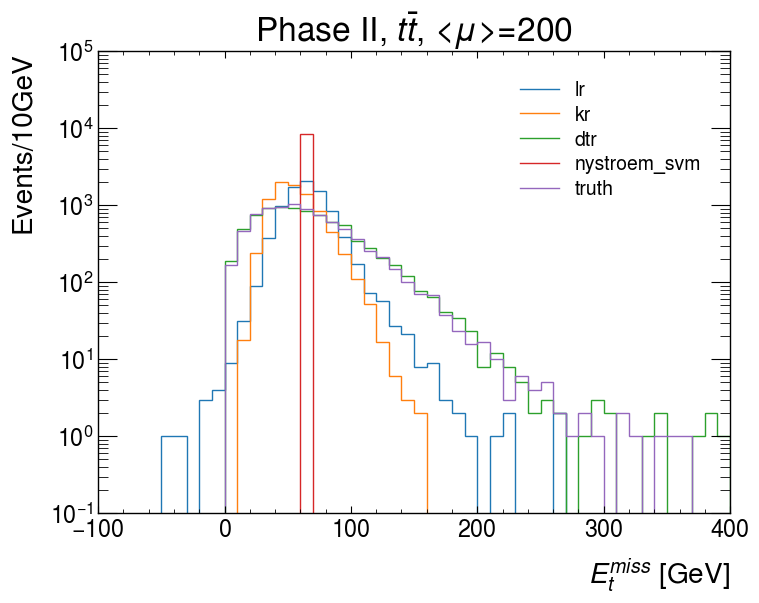

In [33]:
#bin all predicted METs
bins = np.linspace(-100, 400, 51)
fig, axs = plt.subplots()
def get_h(key):
    h, _ = np.histogram(met_pred[key], bins)
    return h
    
hep.histplot([get_h(key) for key in met_pred.keys()],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"$E_{t}^{miss}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=200")

wandb.log({"final_plot_log":wandb.Image(plt)})

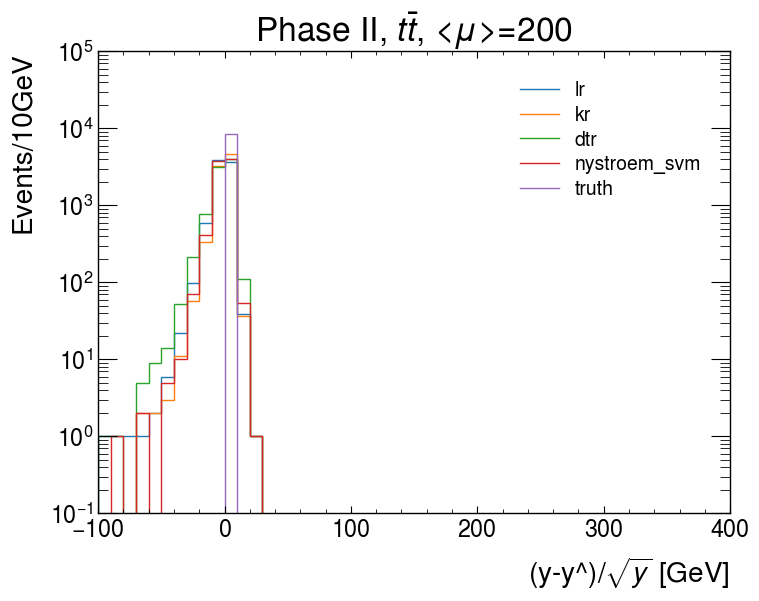

wandb: Network error (ConnectionError), entering retry loop.


In [34]:
#Resolusion

bins = np.linspace(-100, 400, 51)
fig, axs = plt.subplots()
def get_res(key):
    pred = met_pred[key]
    res = (y_test - pred)/np.sqrt(np.abs(y_test))
    h, _ = np.histogram(res, bins)
    return h
    
hep.histplot([get_res(key) for key in met_pred.keys()],bins,
             ax=axs, label=[key for key in met_pred.keys()] )
axs.legend()
axs.set_xlabel(r"(y-y^)/$\sqrt{y}$ [GeV]")
axs.set_ylabel(r"Events/10GeV")
axs.set_yscale('log')
axs.set_title(r"Phase II, $t \bar t$, <$\mu$>=200")

wandb.log({"final_plot_log":wandb.Image(plt)})

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1556452e0>, cbar=<matplotlib.colorbar.Colorbar object at 0x1556456d0>, text=[])

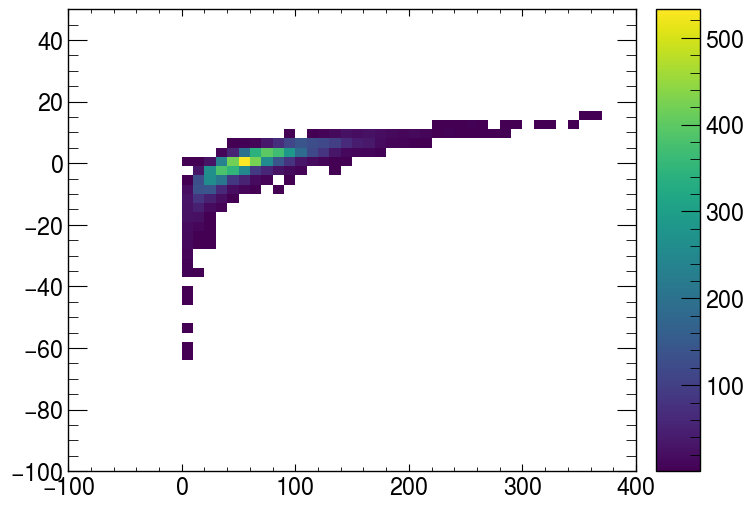

In [30]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], (y_test - met_pred['kr'])/np.sqrt(np.abs(y_test)) , bins=(bins, np.linspace(-100, 50, 51)))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1562f0a60>, cbar=<matplotlib.colorbar.Colorbar object at 0x1562f0e50>, text=[])

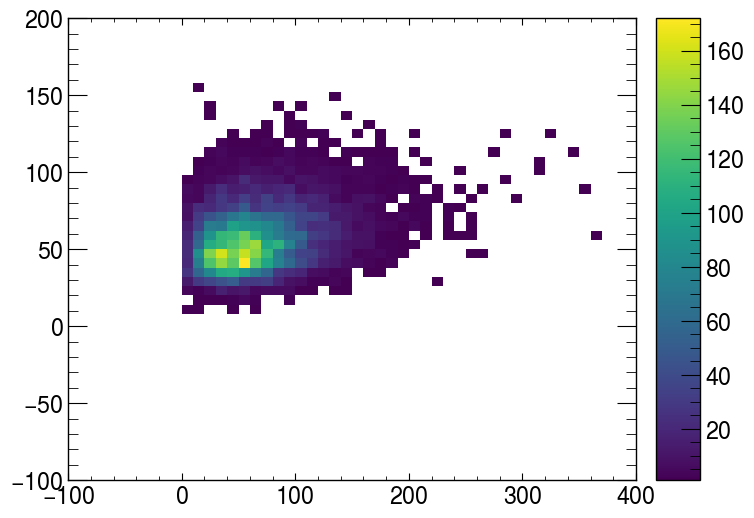

In [31]:
fig2D, axs2D = plt.subplots()
H, xedges, yedges = np.histogram2d(met_pred['truth'], met_pred['kr'], bins=(bins, np.linspace(-100, 200, 51)))
H[H==0]=np.NaN
hep.hist2dplot(H, xedges, yedges)


In [32]:
scores

,train,test_r2,chi2
lr,0.222217,-0.027573,370344.516192
kr,0.363372,-0.008775,266231.625000
dtr,1.000000,-0.920053,634270.045706
nystroem_svm,-0.027542,-0.019473,296810.406374
